In [66]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import h5py
from math import pi

from analysis.config import birds, h5_path_dict, pickle_dir
from analysis.ExpData import ExpData
from analysis.EpisodeCalc import EpisodeCalc

In [ ]:
with open(pickle_dir / 'episode_cells.p', 'rb') as f: 
    ep_cells = pickle.load(f)

In [ ]:
with open(pickle_dir / 'place_cells_1d.p', 'rb') as f:
    place_cells = pickle.load(f)

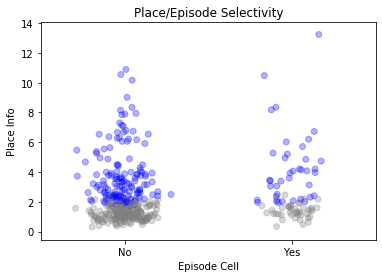

In [62]:
plt.figure()
neither = 0
pl_only = 0
ep_only = 0
both = 0
both_matrix = np.zeros((16, 16)) # cache by nav
for key in place_cells.keys():
    f = h5py.File(key, 'r')
    exp_data = ExpData(f)
    cr_idx_mat = ep_cells[key]['cr_idx_mat']
    fr_mat = np.zeros((16, exp_data.num_neurs))
    for i in np.arange(16):
        fr_site = exp_data.fr[:,exp_data.wedges == (i+1)]
        fr_site = np.mean(fr_site, axis=1)
        fr_mat[i,:] = fr_site
    ep_significance = ep_cells[key]['significance'].astype(int)
    pl_info = place_cells[key]['spatial_info']
    pl_significance = place_cells[key]['significance']
    c = []
    for neur, pl_sig, ep_sig in zip(
            np.arange(exp_data.num_neurs), pl_significance, ep_significance
            ):
        if not pl_sig and not ep_sig:
            c.append("gray")
            neither += 1
        elif pl_sig and not ep_sig:
            c.append("blue")
            pl_only += 1
        elif not pl_sig and ep_sig:
            c.append("gray")
            ep_only += 1
        else:
            c.append("blue")
            both += 1
            #c_tuning = np.argmax(cr_idx_mat[:,neur]).squeeze()
            c_tuning = np.argwhere(cr_idx_mat[:,neur]>0).squeeze()
            c_tuning_sites = exp_data.cr_sites[exp_data.cr_was_cache][c_tuning]
            c_tuning_sites = np.unique(c_tuning_sites).squeeze() - 1
            pl_tuning = np.argmax(fr_mat[:, neur]).squeeze()
            if c_tuning_sites.size == 1:
                c_tun = c_tuning_sites.item()
                both_matrix[c_tun][pl_tuning] += 1
            elif c_tuning_sites.size > 1:
                for c_tun in c_tuning_sites:
                    both_matrix[c_tun][pl_tuning] += 1
    plt.scatter(
        ep_significance+np.random.normal(0, 0.1, ep_significance.size),
        pl_info, c=c, alpha=0.3)
plt.ylabel("Place Info")
plt.xlim(-0.5, 1.5)
plt.xticks([0, 1], ["No", "Yes"])
plt.xlabel("Episode Cell")
plt.title("Place/Episode Selectivity")
plt.show()

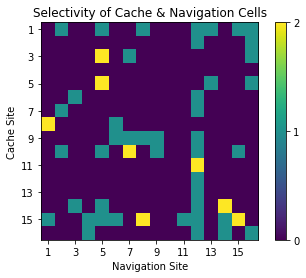

In [65]:
plt.imshow(both_matrix)
plt.xticks(np.arange(0, 16, 2), np.arange(0, 16, 2)+1)
plt.yticks(np.arange(0, 16, 2), np.arange(0, 16, 2)+1)
plt.xlabel("Navigation Site")
plt.ylabel("Cache Site")
plt.title("Selectivity of Cache & Navigation Cells")
plt.colorbar(ticks=(0,1,2))
plt.show()

In [19]:
total = neither + pl_only + ep_only + both
perc_neither = neither/total
perc_pl = pl_only/total
perc_ep = ep_only/total
perc_both = both/total
print(f"Total Cells: {total}")
print(f"Percent Neither: {perc_neither:0.2f}")
print(f"Percent Place-Only: {perc_pl:0.2f}")
print(f"Percent Ep-Only: {perc_ep:0.2f}")
print(f"Percent Both: {perc_both:0.2f}")